In [1]:


import numpy as np
import pandas as pd
import torch
from kan import KAN as PyKAN
from torch import nn, optim
from tqdm import tqdm

from efficient_kan.kan import KAN as EffKAN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Load dataset

In [2]:
def create_dataset(train_x: torch.Tensor, train_y: torch.Tensor, test_size=0.3):
    indices = torch.randperm(train_x.shape[0])
    test_size = int(train_x.shape[0] * test_size)
    test_indices, train_indices = indices[:test_size], indices[test_size:]
    return {'train_input': train_x[train_indices].to(device), 'test_input': train_x[test_indices].to(device),
            'train_label': train_y[train_indices].to(device), 'test_label': train_y[test_indices].to(device)}

In [157]:
USE_SYNTHETIC_DATASET = False  # Generated with 2-Synthetic_Dataset.ipynb

if USE_SYNTHETIC_DATASET:
    df = pd.read_csv('dataset/synthetic.csv')
    df_normalized = (df - df.mean()) / df.std()
    df_x_normalized = df_normalized.drop(columns=['label'])
    df_y_normalized = df_normalized['label']
else:
    df_x = pd.read_csv('dataset/X_train.csv').drop(columns=['id'])
    df_y = pd.read_csv('dataset/y_train.csv').drop(columns=['id', 'faulty'])
    df_y['trq_target'] = df_x['trq_measured'] / (df_y['trq_margin'] / 100 + 1)
    df_x_normalized = (df_x - df_x.mean()) / df_x.std()
    df_y_normalized = (df_y['trq_target'] - df_y['trq_target'].mean()) / df_y['trq_target'].std()
    df_x_normalized.drop(columns=['trq_measured'], inplace=True)

train_x_1 = torch.tensor(df_x_normalized.values, dtype=torch.float32, device=device)
train_y_1 = torch.tensor(df_y_normalized.values, dtype=torch.float32, device=device).unsqueeze(1)
assert (train_x_1.shape[0] == train_y_1.shape[0])

In [158]:
# Downsample to 10%
random_indices = np.random.choice(train_x_1.shape[0], size=train_x_1.shape[0] // 10, replace=False)
train_x_10 = train_x_1[random_indices]
train_y_10 = train_y_1[random_indices]
# Downsample to 1%
random_indices = np.random.choice(train_x_1.shape[0], size=train_x_1.shape[0] // 100, replace=False)
train_x_100 = train_x_1[random_indices]
train_y_100 = train_y_1[random_indices]

In [337]:
def train(model, optimizer, inputs: torch.Tensor, labels, epochs=5, batch_size=100, deterministic=False):
    criterion_stochastic = nn.GaussianNLLLoss(reduction='mean')
    criterion_deterministic = nn.MSELoss()
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)
    for epoch in range(epochs):
        model.train()
        with tqdm(range(inputs.size(0) // batch_size)) as pbar:
            for i in pbar:
                x = inputs[i * batch_size:(i + 1) * batch_size]
                y = labels[i * batch_size:(i + 1) * batch_size]
                optimizer.zero_grad()
                if deterministic:
                    output = model(x)
                    loss = criterion_deterministic(output, y)
                else:
                    mu, log_var = model(x)
                    loss = criterion_stochastic(mu, y.squeeze(), torch.exp(log_var))
                loss.backward()
                optimizer.step(closure=lambda: loss)
                pbar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])
        scheduler.step()

### Train the KAN

In [330]:
class Py_KAN(nn.Module):
    def __init__(self, layers, grid_size=8):
        super(Py_KAN, self).__init__()
        self.model = PyKAN(width=layers, grid=grid_size, k=3, device=device)

    def forward(self, x):
        x = self.model(x)
        mu = x[:, 0]
        var = x[:, 1]
        return mu, var

In [338]:
pyKAN = Py_KAN(layers=[6, 1, 2], grid_size=2)

checkpoint directory created: ./model
saving model version 0.0


In [341]:
train(pyKAN, optim.Adam(pyKAN.parameters(), lr=0.001), train_x_10, train_y_10, epochs=100,
      batch_size=4096 * 2)

 33%|███▎      | 3/9 [00:00<00:00, 30.01it/s, loss=-3.52, lr=7.28e-5]


KeyboardInterrupt: 

In [329]:
pyKAN.model.saveckpt('models/torque_target_stochastic_pykan.pt')

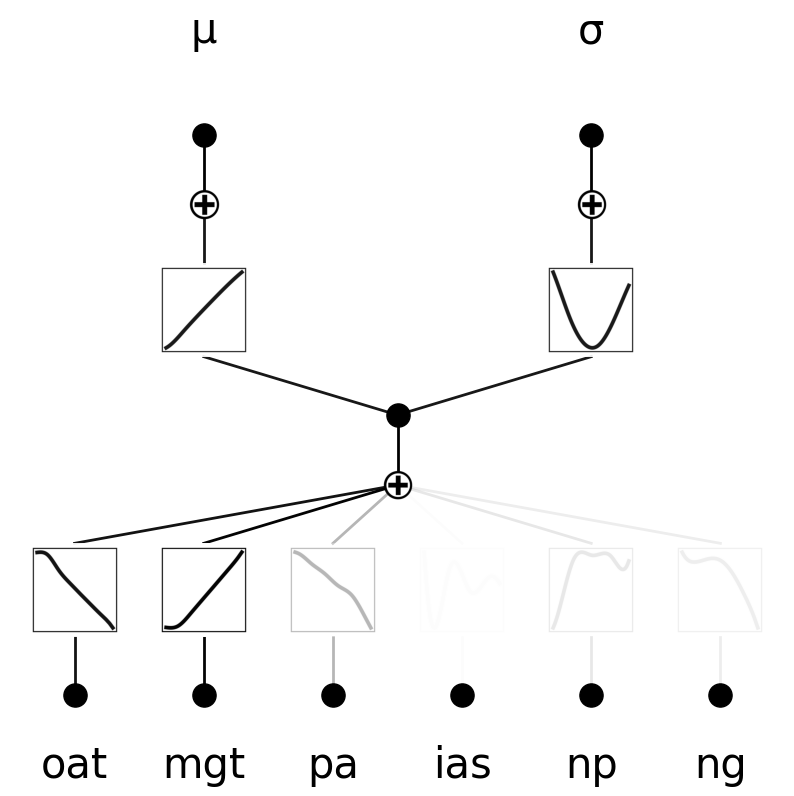

In [342]:
pyKAN.model.plot(scale=1, tick=False, in_vars=['oat', 'mgt', 'pa', 'ias', 'np', 'ng'], out_vars=['μ', 'σ'],
                 varscale=0.75)

In [336]:
y_test = train_y_1[0:3].squeeze()
output = pyKAN(train_x_1[0:3])
print(y_test.round(decimals=3))
print('-------------------------')
print(output[0].round(decimals=3))
print(output[1].round(decimals=3))

tensor([-0.2830, -1.2670, -0.4440], device='cuda:0')
-------------------------
tensor([-0.2920, -1.2690, -0.4360], device='cuda:0', grad_fn=<RoundBackward1>)
tensor([-8.7750, -8.3650, -8.9450], device='cuda:0', grad_fn=<RoundBackward1>)


### Train the EfficientKAN

In [225]:
class Efficient_KAN(nn.Module):
    def __init__(self, layers, grid_size=8):
        super(Efficient_KAN, self).__init__()
        self.model = EffKAN(layers,
                            grid_size=grid_size,
                            # grid_eps=1,
                            # scale_base=0,
                            # sp_trainable=False,
                            # sb_trainable=False,
                            # enable_standalone_scale_spline=False
                            ).to(device)

    def forward(self, x):
        # x = x / dataset_size * 2 - 1
        # x = x.view(-1, self.layers[0])
        x = self.model(x)
        mu = x[:, 0]
        var = x[:, 1]  #F.softplus(x[:, 1]) + 1e-6
        return mu, var

In [226]:
efficientKAN = Efficient_KAN(layers=[6, 6, 2], grid_size=5)

In [227]:
train(efficientKAN, optim.Adam(efficientKAN.parameters(), lr=0.01), train_x_1, train_y_1, epochs=50,
      batch_size=4096)

100%|██████████| 18/18 [00:00<00:00, 111.18it/s, loss=-3.92, lr=0.00081]


In [229]:
torch.save(efficientKAN.model.state_dict(), 'models/torque_target_stochastic_effkan.pt')

In [206]:
efficientKAN.eval()
for i in range(10):
    x_test = train_x_1[i].unsqueeze(0)
    y_test = train_y_1[i].unsqueeze(0)
    output = efficientKAN(x_test)
    print(y_test[0].item().__round__(2), '=>', output[0].item().__round__(3), output[1].item().__round__(3))

-0.28 => -0.394 -1.851
-1.27 => -1.271 -11.849
-0.44 => -0.435 -10.134
-0.3 => -0.317 -8.138
-0.57 => -0.572 -12.036
-0.86 => -0.857 -11.363
1.49 => 1.842 -4.168
-0.82 => -0.83 -7.416
1.07 => 1.063 -6.2
2.14 => 2.286 -3.543


### MLP training

In [187]:
class MLP(nn.Module):
    def __init__(self, layers_size, deterministic=False):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(layers_size) - 1):
            layers.append(nn.Linear(layers_size[i], layers_size[i + 1]))
            if i < len(layers_size) - 2:  # Add activation for all layers except the last one
                layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)
        self.deterministic = deterministic

    def forward(self, x):
        output = self.model(x)
        if self.deterministic:
            return output
        else:
            mu = output[:, 0]
            var = output[:, 1]
            return mu, var

In [188]:
mlp = MLP([6, 256, 256, 2], deterministic=False).to(device)

In [194]:
train(mlp, optim.Adam(mlp.parameters(), lr=.01), train_x_10, train_y_10, epochs=50,
      batch_size=4096, deterministic=False)

100%|██████████| 18/18 [00:00<00:00, 225.96it/s, loss=-5.08, lr=0.00081]


In [195]:
mlp.eval()
for i in range(10):
    x_test = train_x_1[i].unsqueeze(0)
    y_test = train_y_1[i].unsqueeze(0)
    output = mlp(x_test)
    print(y_test[0].item().__round__(2), '=>', output[0].item().__round__(3), output[1].item().__round__(3))

-0.28 => -0.284 -10.836
-1.27 => -1.268 -11.312
-0.44 => -0.441 -10.808
-0.3 => -0.303 -10.807
-0.57 => -0.573 -10.687
-0.86 => -0.86 -11.019
1.49 => 1.463 -10.358
-0.82 => -0.819 -10.872
1.07 => 1.067 -10.511
2.14 => 2.148 -10.406


In [231]:
torch.save(mlp.state_dict(), 'models/torque_target_stochastic_mlp.pt')